In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
import os
from pprint import pprint
import datetime as dt
import matplotlib.dates as mdates
# Pretty display for notebooks
%matplotlib inline

In [2]:
import time
from datetime import date
today = date.today()
start = '2012-06-01'
end = today

In [3]:
google = data.DataReader('GOOG', 'yahoo', start, end)
facebook = data.DataReader('FB', 'yahoo', start, end)
amazon = data.DataReader('AMZN', 'yahoo', start, end)
apple = data.DataReader('AAPL', 'yahoo', start, end)
tesla = data.DataReader('TSLA', 'yahoo', start, end)
microsoft = data.DataReader('MSFT', 'yahoo', start, end)
yahoo = data.DataReader('YHOO', 'yahoo', start, end)
IBM = data.DataReader('IBM', 'yahoo', start, end)
cisco = data.DataReader('CSCO', 'yahoo', start, end)
nvidia = data.DataReader('NVDA', 'yahoo', start, end)

In [4]:
tech_stocks = {'IBM':IBM, 'CSCO': cisco, 'NVDA':nvidia, 'GOOG':google, 
               'FB':facebook, 'AMZN':amazon, 'AAPL': apple, 'TSLA': tesla, 
               'MSFT': microsoft, 'YHOO':yahoo}

In [5]:
def fill_missing_values(df):
    df.fillna(method='ffill', inplace=True) #propagate last valid observation forward to next valid backfill
    return df
def normalize_data(df):
    """Normalize stock prices so they all start at 1"""
    return df/df.ix[0,:]

In [6]:
#rolling mean benchmark
def rollingMean_benchmark(X,y):
    y_pred = []
    k = 5
    for i in range(k+1, len(X)):
        rm = target_stock.iloc[:i]['Adj Close'].rolling(window=k, center=False).mean()
        x = rm.iloc[-1]
        y_pred.append(x)
        y_true = list(y[k+1:])
    assert len(y_true)==len(y_pred)
    error = [float('{0:.3g}'.format(np.absolute(i-j)/i)) for (i, j) in zip(y_true,y_pred)]
    squared_error = [float((i-j))**2 for (i, j) in zip(y_true,y_pred)]
    return y_pred, y_true, error, np.mean(squared_error)

In [7]:
#produce the MSE of rolling mean benchmark model
for key,val in tech_stocks.items():
    target_stock = val
    target_stock = fill_missing_values(target_stock)
    X = normalize_data(target_stock[['Open', 'High', 'Low', 'Close', 'Volume']])
    y = target_stock['Adj Close']
    y_pred, y_true, error, mse = rollingMean_benchmark(X,y)
    print(key, float('{0:.3g}'.format(mse)))

('GOOG', 155.0)
('FB', 4.4)
('IBM', 7.52)
('TSLA', 61.9)
('YHOO', 0.83)
('AMZN', 155.0)
('CSCO', 0.215)
('AAPL', 4.51)
('MSFT', 0.779)
('NVDA', 3.29)


<function matplotlib.pyplot.show>

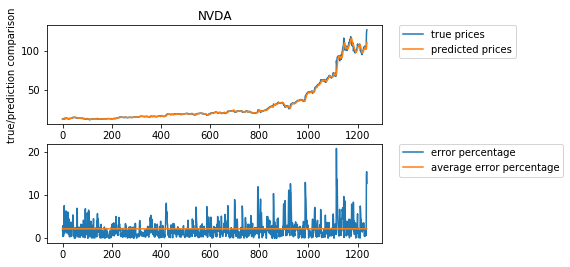

In [8]:
#generate plot for comparison
plt.subplot(211)
plt.plot(y_true, label="true prices")
plt.plot(y_pred, label="predicted prices")
plt.ylabel('true/prediction comparison')
plt.title(key)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(212)
plt.plot([e*100 for e in error], label="error percentage")
plt.plot([np.mean(error)*100] * len(error), label="average error percentage")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show

In [9]:
#construct features for linear regression
def compute_daily_returns(df):
    """Compute and return the daily return values."""
    daily_returns = (df/df.shift(1))-1
    daily_returns[0] = 0
    return daily_returns
def stock_go_up(close):
    go_up = [0]
    for i in range(1,len(close)):
        cur = close[i]-close[i-1]
        if cur > 0:
            go_up.append(1)
        else:
            go_up.append(0)
    return go_up

In [10]:
beta = {'IBM': 0.87, 'CSCO':1.42 , 'NVDA': 1.48 ,'GOOG': 0.94, 'FB': 0.47,'AMZN':1.39 ,'AAPL':1.44,
        'TSLA':1.15 ,'MSFT':1.38, 'YHOO': 1.88}

In [11]:
def add_features(tech_dict):
    """
    A function to create feature dictionaries
    """
    feature_dict = {}
    for key, val in tech_dict.items():
        features = val.loc[:,['Open', 'Volume']]
        features.loc[:,'Open'] = normalize_data(val['Open'])
        features.loc[:,'Volume'] = normalize_data(val['Volume'])
        features.loc[:,'go_up'] = stock_go_up(val['Adj Close'])  
        features.loc[:,'daily_return'] = compute_daily_returns(val['Adj Close'])
        features.loc[:,'daily_fluctuation'] = 100*(val['High'] - val['Low'])/val['Low']
        features.loc[:,'beta'] = [beta[key]]*len(val)
        features.reset_index(inplace=True,drop=False)
        feature_dict[key]=features
    return feature_dict
        

In [12]:
feature_dict = add_features(tech_stocks)

In [13]:
feature_dict['AAPL'].head()

,Date,Open,Volume,go_up,daily_return,daily_fluctuation,beta
0,2012-06-01,1.000000,1.000000,0,0.000000,2.164061,1.44
1,2012-06-04,0.986542,1.069115,1,0.005882,3.463994,1.44
2,2012-06-05,0.986137,0.745151,0,-0.002587,1.457919,1.44
3,2012-06-06,0.997558,0.770567,1,0.015333,1.476568,1.44
4,2012-06-07,1.014284,0.728936,1,0.000455,1.195447,1.44


In [14]:
#study market trend
SP500 = data.DataReader('SPY', 'yahoo', start, end)
SP500.reset_index(inplace=True,drop=False)
DowJones = data.DataReader('^DJI', 'yahoo', start, end) #Dow Jones Industrial Average
DowJones.reset_index(inplace=True,drop=False)
ten_yr_bond = data.DataReader('^TNX', 'yahoo', start, end) #10 year bond
ten_yr_bond.reset_index(inplace=True,drop=False)
nikke = data.DataReader('^N225', 'yahoo', start, end) #nikke index
nikke.reset_index(inplace=True,drop=False)
market_trend = pd.merge(SP500[['Date', 'Adj Close']], DowJones[['Date', 'Adj Close']], on='Date')
market_trend = pd.merge(market_trend, ten_yr_bond[['Date', 'Adj Close']], on='Date')
market_trend = pd.merge(market_trend, nikke[['Date', 'Adj Close']], on='Date')
market_trend.columns = ['Date', 'SP500', 'DowJones', 'ten_yr_bond', 'nikke']

In [15]:
market_trend[['SP500', 'DowJones', 'ten_yr_bond', 'nikke']].corr()

,SP500,DowJones,ten_yr_bond,nikke
SP500,1.000000,0.986987,0.169342,0.900963
DowJones,0.986987,1.000000,0.239934,0.888744
ten_yr_bond,0.169342,0.239934,1.000000,0.301369
nikke,0.900963,0.888744,0.301369,1.000000


In [16]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
def linear_regression(target_feature, tech_stock):
    """
    a function to fit linear regression model
    """
    features = pd.merge(target_feature, market_trend[['Date', 'SP500','ten_yr_bond']], on='Date')
    #print(features.columns.values)
    features = features.loc[:,['Open', 'Volume', 'go_up', 'daily_return', 'daily_fluctuation', 'beta',
                 'SP500', 'ten_yr_bond']]
    target = np.array(tech_stock['Adj Close'])
    training_size = int(len(features)*0.7)
    test_size = len(features) - training_size
    X_train = features.iloc[:training_size]
    y_train = tech_stock['Adj Close'].iloc[:training_size]
    X_test = features.iloc[-test_size:]
    y_test = tech_stock['Adj Close'].iloc[-test_size:]
    assert len(X_train) == len(y_train)
    assert len(X_test) == len(y_test)
    regr.fit(X_train, y_train)
    #make prediction
    y_pred = regr.predict(X_test)
    coefs = regr.coef_ #coefficients
    print('coefs:', coefs)
    mse = np.mean((y_pred - y_test) ** 2) #mean squared error
    score = regr.score(X_test, y_test) #variance score
    return mse, score, y_test, y_pred

('coefs:', array([  2.48610299e+01,  -2.07493459e+01,   4.85283986e+00,
        -2.42752736e+02,   1.46647882e+01,  -1.06581410e-13,
         2.83833499e+00,   5.21178854e+01]))


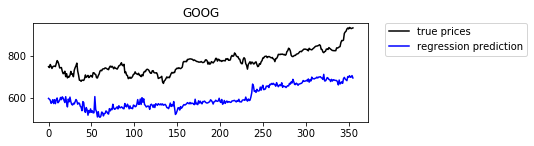

('GOOG', 'mean square error:', 28493.383047952735, 'R^2:', -9.0131609942959532)
('coefs:', array([  1.00814594e+02,   8.34154344e-01,   6.82962111e-01,
        -5.80139166e+01,  -6.84018883e-01,  -8.52651283e-14,
        -4.57735531e-02,   2.32445290e+00]))


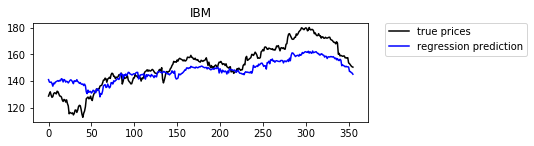

('IBM', 'mean square error:', 105.29069329913219, 'R^2:', 0.58609904791966128)
('coefs:', array([  2.26829708e+01,  -6.69987933e-01,   5.03569782e+00,
        -9.57453562e+01,   1.73611137e+00,  -5.96855898e-13,
         6.81105081e-01,   3.09902289e-01]))


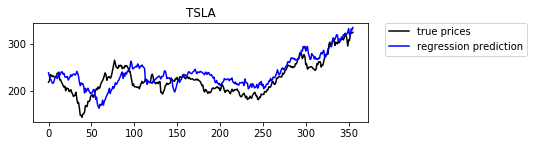

('TSLA', 'mean square error:', 627.6376949112508, 'R^2:', 0.49665586519063376)
('coefs:', array([  3.70955113e+00,  -3.16505840e+00,  -6.06752810e-01,
        -2.95553179e+01,   2.69639002e-01,   2.30926389e-14,
         8.22136596e-01,  -3.19648098e+01]))


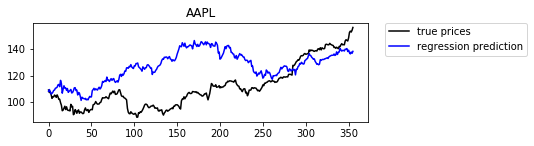

('AAPL', 'mean square error:', 498.85353610087304, 'R^2:', -0.81490673367612865)
('coefs:', array([  1.10045417e+01,  -3.94886224e-01,  -4.51018243e-02,
        -5.57120439e+00,   2.42172093e-01,  -1.33226763e-15,
         4.32706960e-02,  -8.37094808e-02]))


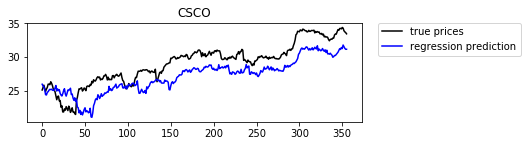

('CSCO', 'mean square error:', 5.474275222641756, 'R^2:', 0.4146936153900127)
('coefs:', array([  2.38958504e+01,  -1.16824467e+00,   1.31005770e+00,
        -2.21654960e+01,   9.39924482e-01,   2.57571742e-14,
         1.43648204e-01,  -2.31524957e+00]))


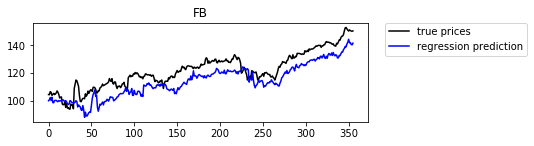

('FB', 'mean square error:', 78.90344873511167, 'R^2:', 0.50880840432649432)
('coefs:', array([  4.81464085e+00,  -1.82222814e-01,   8.07582751e-02,
        -3.17903931e+00,   1.73266291e-01,   2.77555756e-14,
         7.91824014e-02,  -8.14271222e-01]))


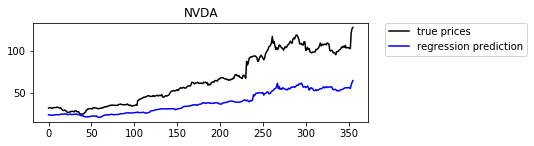

('NVDA', 'mean square error:', 1076.3976200982363, 'R^2:', -0.19612712955688116)
('coefs:', array([  1.02160040e+01,  -7.70588174e-01,   3.04341769e-01,
        -1.59372270e+01,   5.76014474e-01,  -9.59232693e-14,
         1.27012612e-01,  -8.29340994e-01]))


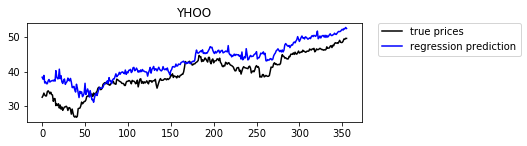

('YHOO', 'mean square error:', 15.18314092958856, 'R^2:', 0.46686540120013764)
('coefs:', array([  1.55276317e+02,  -1.48928050e+00,   6.01810393e+00,
        -1.76120347e+02,   4.23262153e+00,  -3.46870751e-28,
         1.46353729e-01,   1.63271555e+01]))


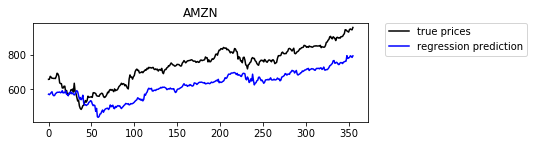

('AMZN', 'mean square error:', 15413.016934437219, 'R^2:', -0.32603136354705486)
('coefs:', array([  1.46900774e+01,  -8.62285906e-01,   3.29096697e-01,
        -2.04299808e+01,   5.15132451e-01,  -1.77635684e-14,
         1.33265931e-01,  -1.40452059e+00]))


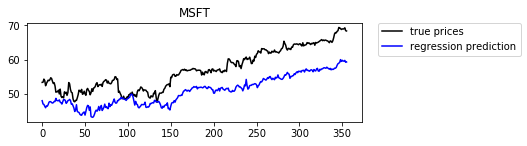

('MSFT', 'mean square error:', 43.663716653990896, 'R^2:', -0.24971142589375209)


In [17]:
#generate visulisation and results for linear regression models
for key,val in feature_dict.items():
    target_feature = val
    tech_stock = tech_stocks[key]
    mse, score, y_test, y_pred = linear_regression(target_feature, tech_stock)
    plt.subplot(211)
    plt.title(key)
    plt.plot(list(y_test), color='black',label='true prices')
    plt.plot(list(y_pred), color='blue', label='regression prediction')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    print(key, 'mean square error:', mse, 'R^2:', score)

In [18]:
#prepare data
all_c = pd.concat([google['Adj Close'],facebook['Adj Close'],amazon['Adj Close'], apple['Adj Close'], 
                   tesla['Adj Close'], microsoft['Adj Close'], yahoo['Adj Close'], IBM['Adj Close'], 
                   cisco['Adj Close'],nvidia['Adj Close']], axis=1)
ticker = ['GOOG', 'FB','AMZN', 'AAPL','TSLA', 'MSFT','YHOO', 'IBM','CSCO','NVDA']
all_c.columns= ticker

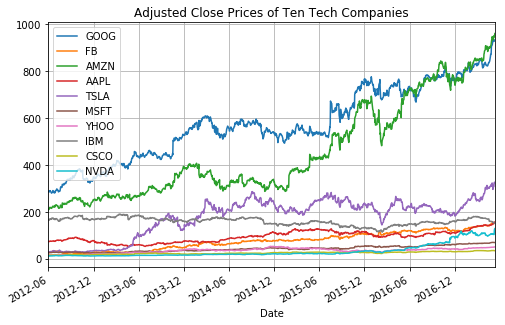

In [19]:
all_c.plot(grid=True, figsize=(8, 5), title = 'Adjusted Close Prices of Ten Tech Companies')

In [20]:
all_c.dropna()

,GOOG,FB,AMZN,AAPL,TSLA,MSFT,YHOO,IBM,CSCO,NVDA
Date,,,,,,,,,,
2012-06-01,285.205295,27.719999,208.220001,72.382840,28.150000,24.942239,14.920000,164.548537,13.673102,11.135949
2012-06-04,289.006480,26.900000,214.570007,72.808629,27.879999,25.029908,15.010000,164.078590,13.801609,10.903563
2012-06-05,284.920579,25.870001,213.210007,72.620256,27.910000,24.994841,15.100000,164.652964,13.810177,11.219608
2012-06-06,289.995487,26.809999,217.639999,73.733758,29.219999,25.731273,15.360000,168.821511,14.298502,11.517063
2012-06-07,288.826666,26.309999,218.800003,73.767302,28.930000,25.626067,15.360000,169.213125,14.204263,11.052291
2012-06-08,289.935570,27.100000,218.479996,74.876932,30.080000,25.994283,15.650000,169.822303,14.332769,11.266086
2012-06-11,283.966519,27.010000,216.500000,73.696334,29.120001,25.336755,15.300000,167.533518,14.118591,11.396222
2012-06-12,282.268201,27.400000,216.419998,74.340181,29.660000,25.678671,15.470000,169.308854,14.384173,11.628609
2012-06-13,280.265216,27.270000,214.729996,73.824075,29.770000,25.538397,15.340000,168.046981,14.272800,11.321859


In [21]:
all_c.describe()

,GOOG,FB,AMZN,AAPL,TSLA,MSFT,YHOO,IBM,CSCO,NVDA
count,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000
mean,575.463687,75.648875,456.836716,93.537599,178.769599,41.719142,34.372145,159.424751,23.678791,31.028616
std,154.772112,37.233110,206.595609,23.537848,80.379304,12.154704,9.537858,15.583139,4.960217,27.675315
min,279.246220,17.730000,208.220001,51.132658,26.100000,23.463078,14.650000,112.683210,13.014102,10.578223
25%,444.666094,41.279999,295.859985,72.328045,138.949997,31.041564,27.969999,148.317687,20.044570,14.148395
50%,558.172777,76.290001,370.559998,94.299041,206.270004,41.599548,36.169998,162.632789,23.357459,19.101762
75%,717.000000,107.910004,626.549988,111.201059,234.240005,50.913885,41.410000,171.147216,27.061911,32.397280
max,934.299988,152.779999,961.349976,156.100006,325.220001,69.410004,52.369999,190.226456,34.389999,127.889999


In [22]:
def sqrt_transform(series):
    """
    function to perform square root transformation on data
    """
    return np.sqrt(series)
def log_transform(series):
    """
    function to perform log transformation on data
    """
    return np.log(series)
def exp_transform(series): 
    """
    a function to perform exponential transformation on log-transformed data
    """
    return np.exp(series)

In [23]:
def forward_validation(fold, features, target, clf):
    num_fold = (len(merged_df)-120)/20
    mse = []
    r2 = []
    for i in range(num_fold):
        X_train = features.iloc[i*20:i*20+fold]
        y_train = target.iloc[i*20:i*20+fold]
        X_test = features.iloc[i*20+fold:(i+1)*20+fold]
        y_test = target.iloc[i*20+fold:(i+1)*20+fold]
        clf.fit(X_train, y_train)
        #make prediction
        y_pred = clf.predict(X_test)
        #print('Coefficients: \n', clf.coef_)
        # The mean squared error
        mse.append(np.mean((y_pred - y_test) ** 2))
        r2.append(clf.score(X_test, y_test))
    return mse, r2

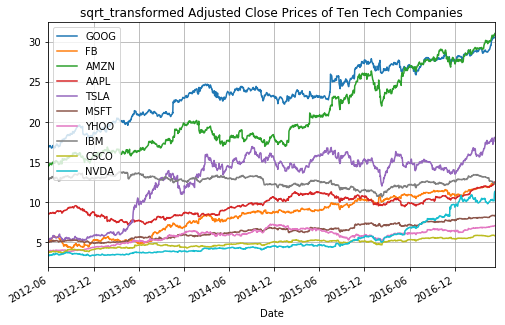

In [24]:
sqrt_transformed = sqrt_transform(all_c)
sqrt_transformed.plot(grid=True, figsize=(8, 5), title = 'sqrt_transformed Adjusted Close Prices of Ten Tech Companies')

In [25]:
log_transformed = log_transform(all_c)
log_transformed.reset_index(inplace=True,drop=False)

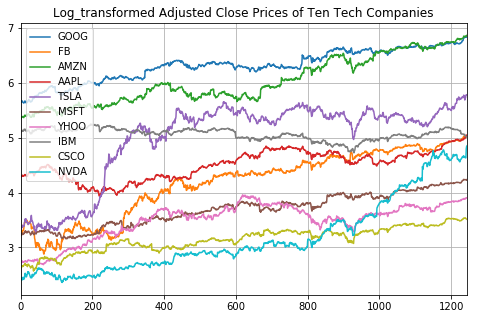

In [26]:

log_transformed.plot(grid=True, figsize=(8, 5), title = 'Log_transformed Adjusted Close Prices of Ten Tech Companies')

In [27]:
def calculate_mse(y_true, y_pred):
    return np.mean((np.exp(y_true-y_pred))**2)

('Overall Fit for :', 'GOOG')


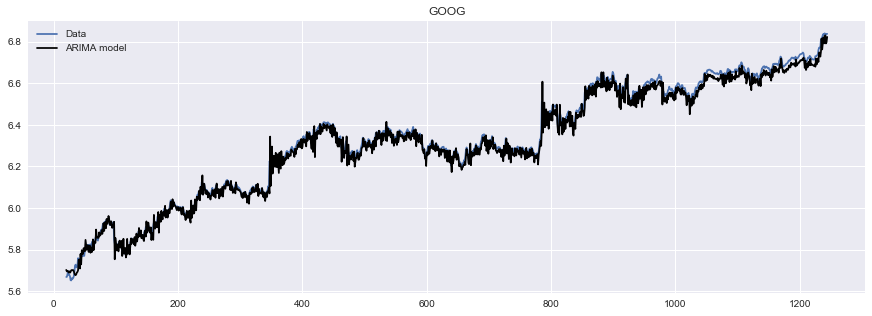

('Rolling Prediction for:', 'GOOG')


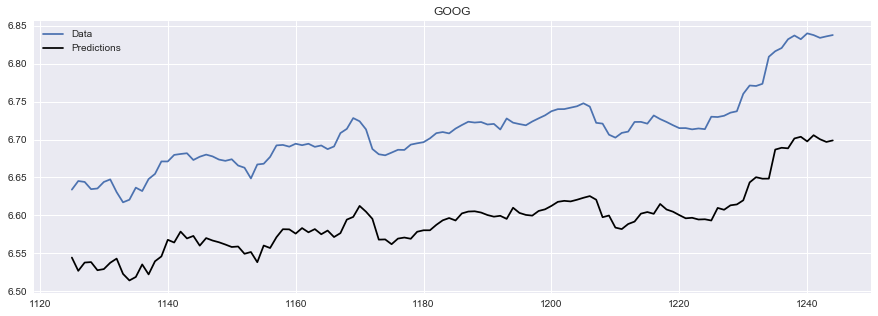

('120 day mse:', 1.2662779513128128)
('next five days predictions for', 'GOOG', array([[ 894.6333032 ],
       [ 829.69706211],
       [ 782.3141161 ],
       [ 750.39963462],
       [ 721.36578709]]))
('Overall Fit for :', 'FB')


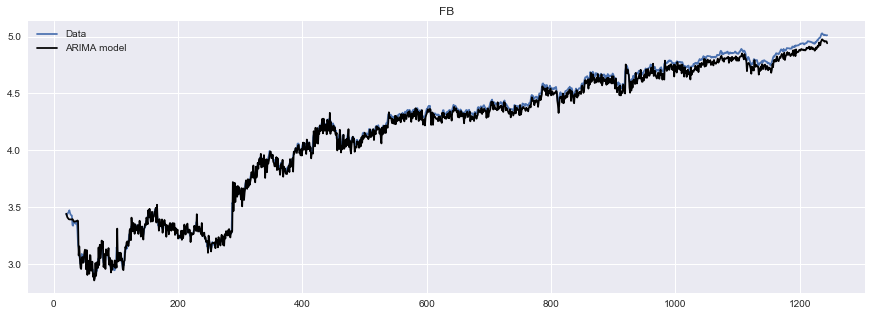

('Rolling Prediction for:', 'FB')


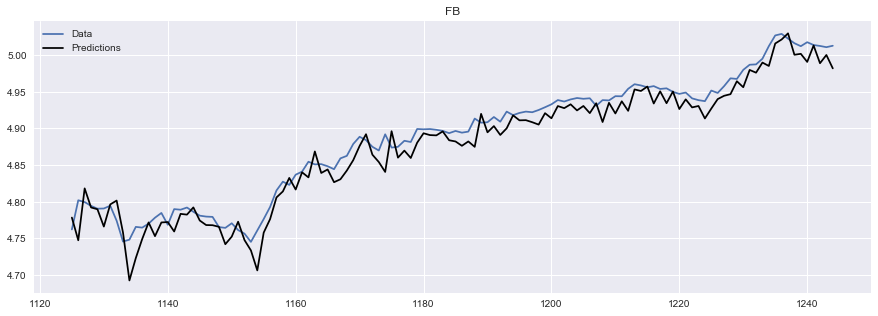

('120 day mse:', 1.0249959269371758)
('next five days predictions for', 'FB', array([[ 142.69645454],
       [ 128.68892034],
       [ 113.55246568],
       [  99.78111217],
       [  86.91690464]]))
('Overall Fit for :', 'AMZN')


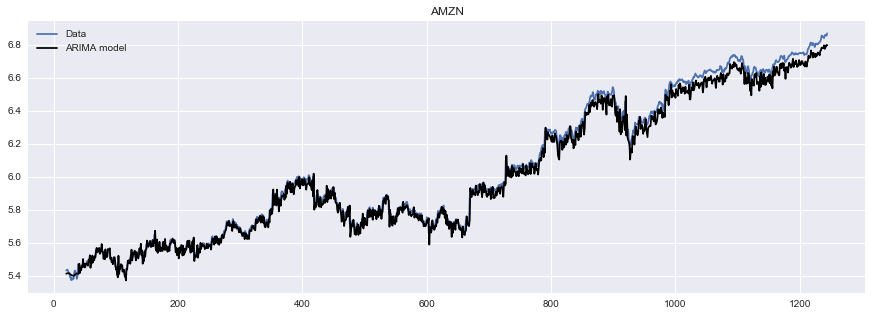

('Rolling Prediction for:', 'AMZN')


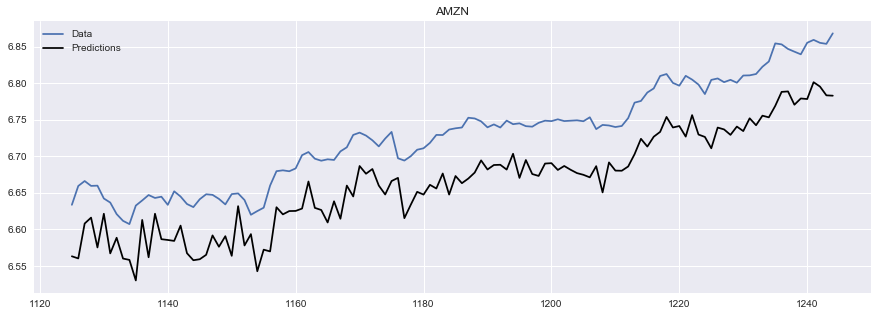

('120 day mse:', 1.1365208882643132)
('next five days predictions for', 'AMZN', array([[ 913.53106822],
       [ 817.46241219],
       [ 732.99294367],
       [ 663.18656467],
       [ 604.55151982]]))
('Overall Fit for :', 'AAPL')


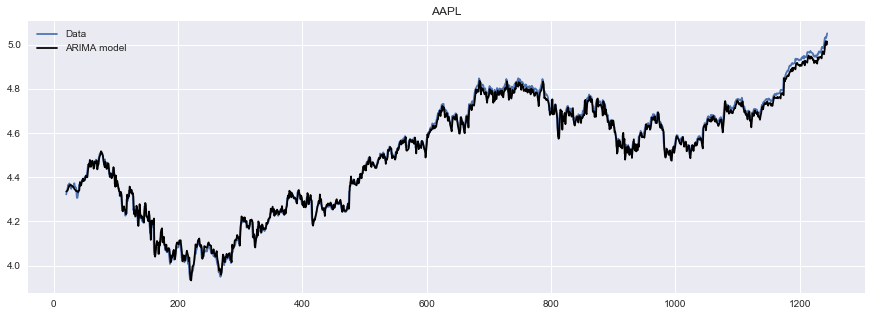

('Rolling Prediction for:', 'AAPL')


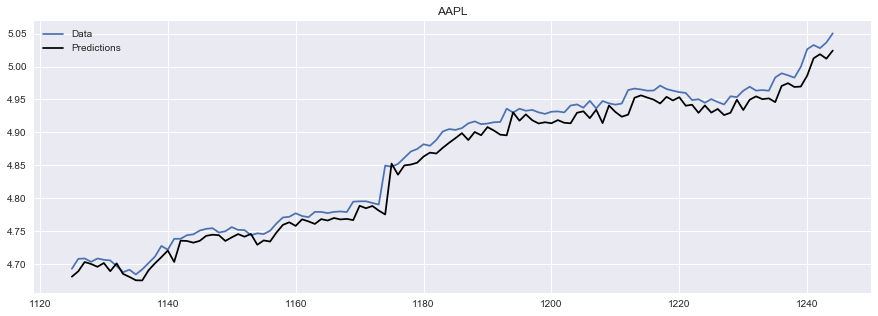

('120 day mse:', 1.0301367132391721)
('next five days predictions for', 'AAPL', array([[ 152.13626046],
       [ 147.0658126 ],
       [ 141.24572186],
       [ 134.05806887],
       [ 127.57480162]]))
('Overall Fit for :', 'TSLA')


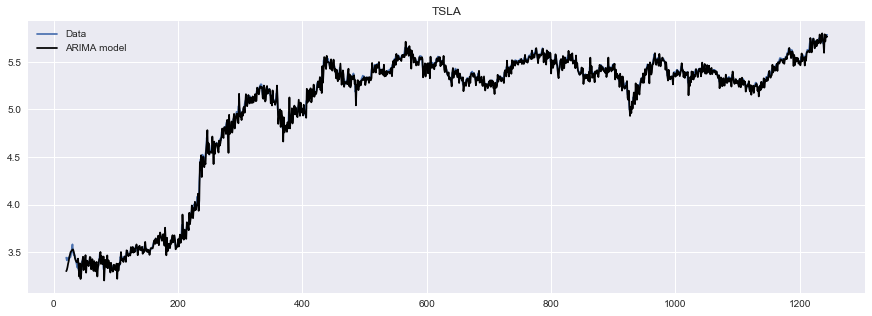

('Rolling Prediction for:', 'TSLA')


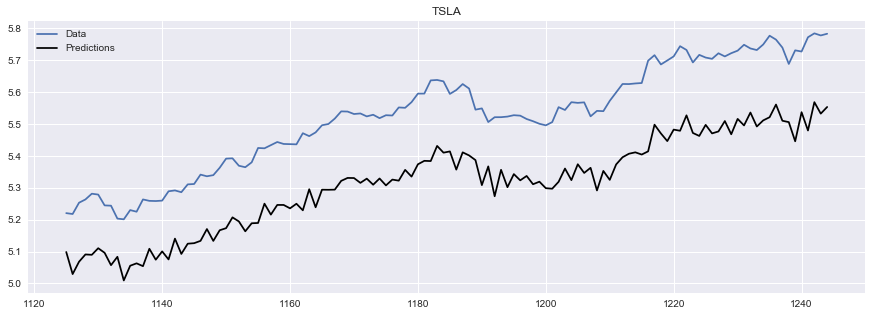

('120 day mse:', 1.5175054228869433)
('next five days predictions for', 'TSLA', array([[ 313.36355124],
       [ 305.11965212],
       [ 292.08328568],
       [ 276.06737243],
       [ 263.87278706]]))
('Overall Fit for :', 'MSFT')


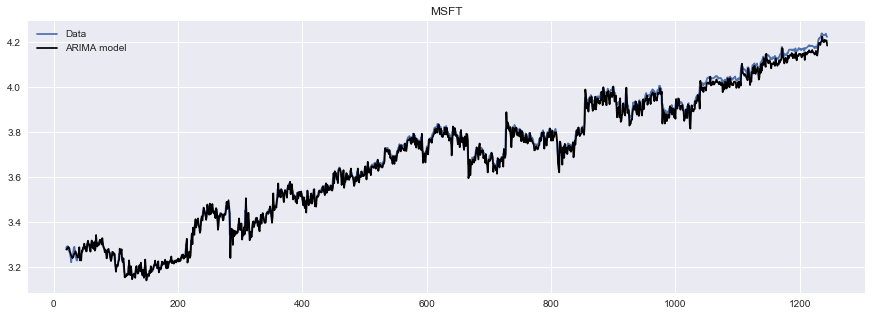

('Rolling Prediction for:', 'MSFT')


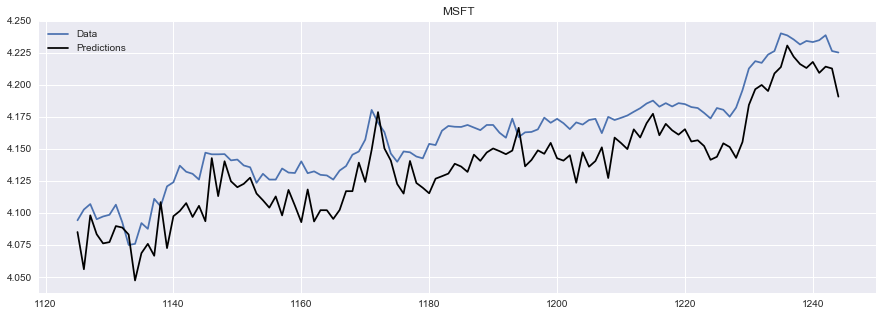

('120 day mse:', 1.0468222771912903)
('next five days predictions for', 'MSFT', array([[ 66.41286171],
       [ 63.37138065],
       [ 59.06840083],
       [ 53.75499438],
       [ 48.45654158]]))
('Overall Fit for :', 'YHOO')


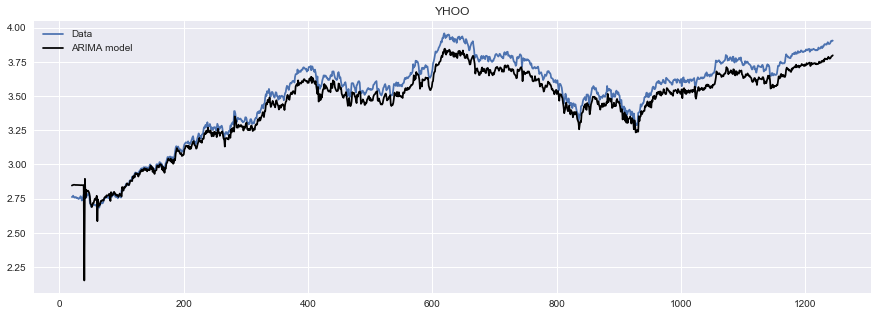

('Rolling Prediction for:', 'YHOO')


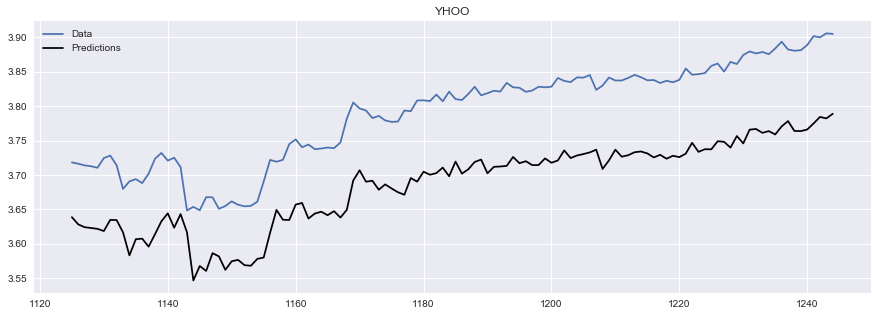

('120 day mse:', 1.2295870971414147)
('next five days predictions for', 'YHOO', array([[ 44.54780357],
       [ 39.44924007],
       [ 35.315463  ],
       [ 31.98161203],
       [ 28.998248  ]]))
('Overall Fit for :', 'IBM')


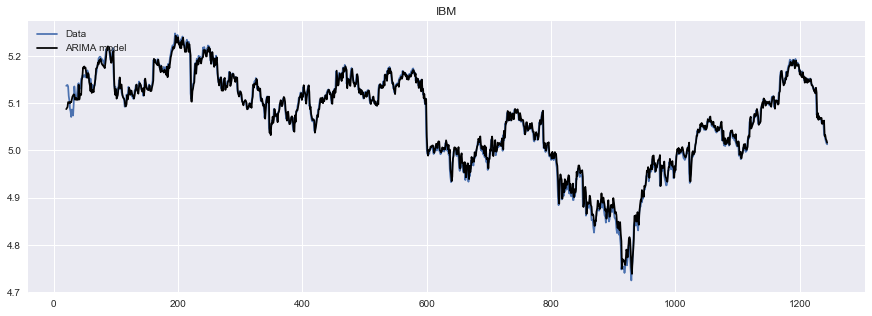

('Rolling Prediction for:', 'IBM')


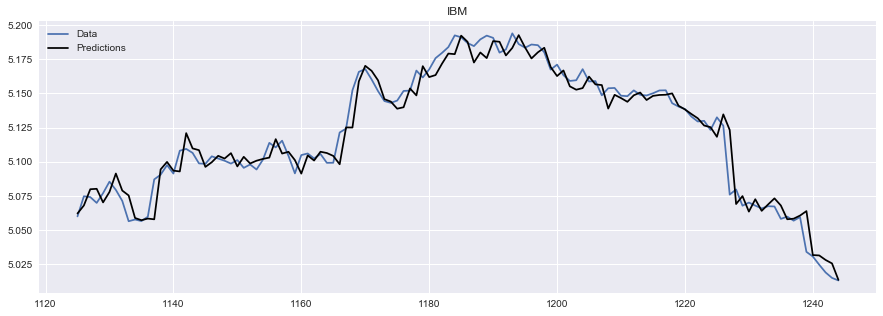

('120 day mse:', 1.0012181949040166)
('next five days predictions for', 'IBM', array([[ 151.35225207],
       [ 152.54705062],
       [ 153.2094566 ],
       [ 153.85922464],
       [ 154.19224004]]))
('Overall Fit for :', 'CSCO')


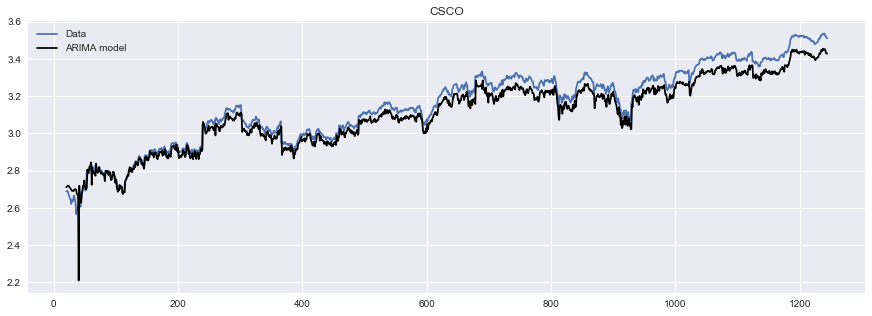

('Rolling Prediction for:', 'CSCO')


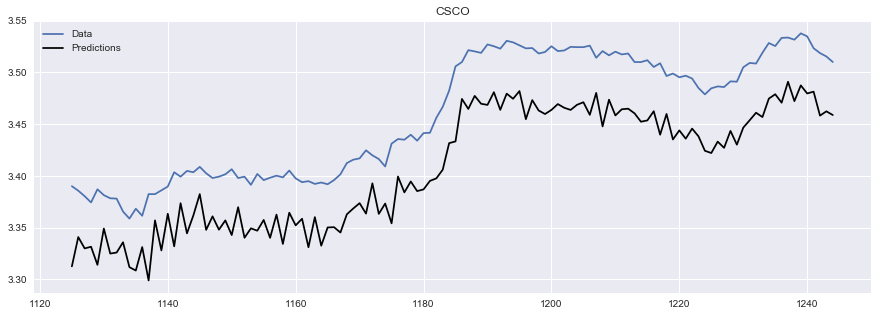

('120 day mse:', 1.1085326606367611)
('next five days predictions for', 'CSCO', array([[ 30.62988024],
       [ 27.28440191],
       [ 24.02362012],
       [ 20.96293429],
       [ 18.21554237]]))
('Overall Fit for :', 'NVDA')


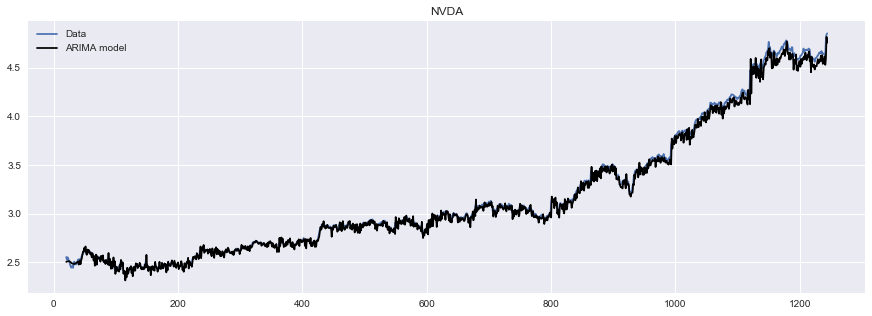

('Rolling Prediction for:', 'NVDA')


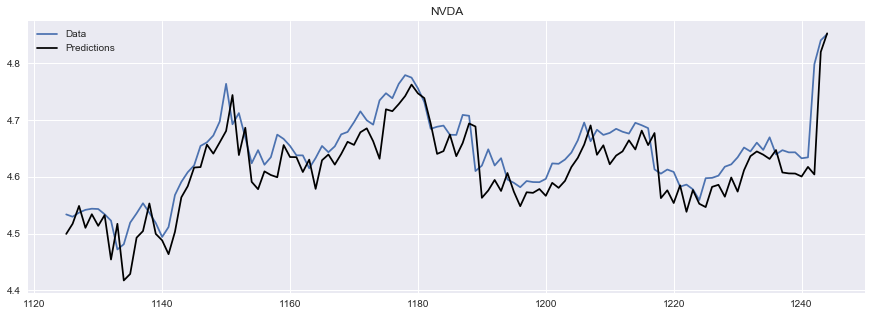

('120 day mse:', 1.058457744319786)
('next five days predictions for', 'NVDA', array([[ 123.16157333],
       [ 112.01775669],
       [  93.62705388],
       [  83.01449725],
       [  74.43174533]]))


In [31]:
# ARIMA model
import pyflux as pf
for i in range(len(ticker)):
    next_day = {}
    model= pf.ARIMA(data=log_transformed.loc[:, ['Date', ticker[i]]],ar=20,ma=20,integ=0,target=ticker[i])
    x_mle = model.fit("MLE") #maximum likelihood estimate
    #print(x_mle.summary())
    print('Overall Fit for :', ticker[i])
    model.plot_fit(figsize=(15,5))
    print('Rolling Prediction for:', ticker[i])
    #rolling in-sample prediction to get an idea of performance
    model.plot_predict_is(120,figsize=(15,5))
    pred = model.predict(h=5)
#     y_true = np.array(log_transformed.loc[:, [ticker[i]]][-600:])
#     y_pred = np.array(model.predict_is(600))
#     print('mse:', calculate_mse(y_true, y_pred))
    y_true = np.array(log_transformed.loc[:, [ticker[i]]][-120:])
    y_pred = np.array(model.predict_is(120))
    print('120 day mse:', calculate_mse(y_true,y_pred))
    pred[ticker[i]] = exp_transform(pred[ticker[i]])
    print('next five days predictions for', ticker[i], pred.values.reshape(len(pred), 1))
    